In [1]:
import warnings

import cudaq
import matplotlib.pyplot as plt
import pandas as pd
from bigdatavqa.ansatz import get_QAOA_circuit, get_VQE_circuit
from bigdatavqa.coreset import BFL2, D2_sampling
from bigdatavqa.divisiveclustering import (
    DivisiveClusteringKMeans,
    DivisiveClusteringMaxCut,
    DivisiveClusteringRandom,
    DivisiveClusteringVQA,
)
from bigdatavqa.Hamiltonians import get_K2_Hamiltonian
from bigdatavqa.optimizer import get_optimizer_for_QAOA, get_optimizer_for_VQE

warnings.filterwarnings("ignore")

In [2]:
number_of_qubits = 10
circuit_depth = 1
max_shots = 1000
max_iterations = 100
number_of_coresets_to_evaluate = 15
number_of_sampling_for_centroids = 20
threshold_for_max_cut = 0.7

## Coresets
The next step is to create coreset from the raw data. 

In [3]:
raw_data = BFL2.create_dataset(1000)

coreset = BFL2(
    raw_data=raw_data,
    number_of_sampling_for_centroids=10,
    coreset_size=10,
    number_of_coresets_to_evaluate=4,
    sampling_method=D2_sampling,
)

coreset_vectors, coreset_weights = coreset.get_best_coresets()

In [4]:
vector_columns = ["X", "Y"]
weights_column = "weights"

coreset_df = pd.DataFrame(coreset_vectors, columns=list("XY"))
coreset_df[weights_column] = coreset_weights
coreset_df["Name"] = [chr(i + 65) for i in coreset_df.index]
coreset_df

,X,Y,weights,Name
0,-1.016813,0.966257,192.087515,A
1,-0.165540,0.193858,225.946279,B
2,7.848737,0.386082,151.846828,C
3,-0.824410,0.052905,77.303788,D
4,7.060604,1.659004,190.616201,E
5,1.451705,-2.271912,26.396594,F
6,3.502512,-2.577412,8.255941,G
7,-0.770874,-0.252800,79.357534,H
8,1.081673,-2.004293,38.914673,I
9,6.091171,1.169192,126.688990,J


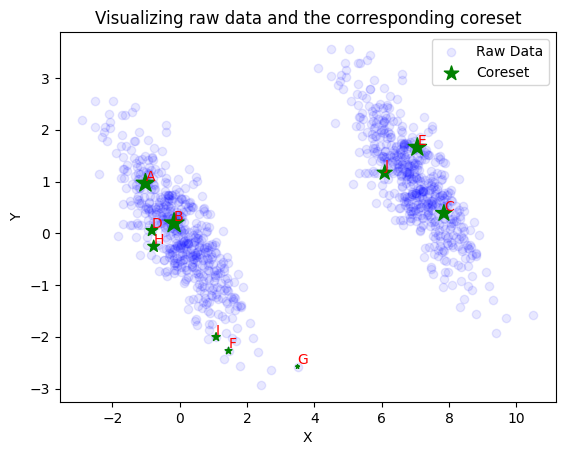

In [5]:
plt.scatter(raw_data[:, 0], raw_data[:, 1], color="blue", alpha=0.09, label="Raw Data")
plt.scatter(
    coreset_df.X,
    coreset_df.Y,
    s=coreset_df.weights,
    marker="*",
    color="green",
    label="Coreset",
)
for idx, row in coreset_df.iterrows():
    plt.annotate(row["Name"], xy=(row.X, row.Y + 0.05), color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Visualizing raw data and the corresponding coreset")
plt.show()

## VQE Clustering

In [6]:
optimizer = cudaq.optimizers.COBYLA()

VQE_divisive_clustering = DivisiveClusteringVQA(
    coreset_df=coreset_df,
    vector_columns=["X", "Y"],
    weights_column="weights",
    circuit_depth=circuit_depth,
    max_iterations=max_iterations,
    max_shots=max_shots,
    threshold_for_max_cut=0.75,
    create_Hamiltonian=get_K2_Hamiltonian,
    optimizer=optimizer,
    optimizer_function=get_optimizer_for_VQE,
    create_circuit=get_VQE_circuit,
    normalize_vectors=True,
    sort_by_descending=True,
    coreset_to_graph_metric="dist",
)

VQE_divisive_clustering.fit()

VQE_cost = VQE_divisive_clustering.cost

print(f"VQE cost: {VQE_cost}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27869.13it/s]

VQE cost: 107.17223537473721


### Exploring results

#### Dendrogram

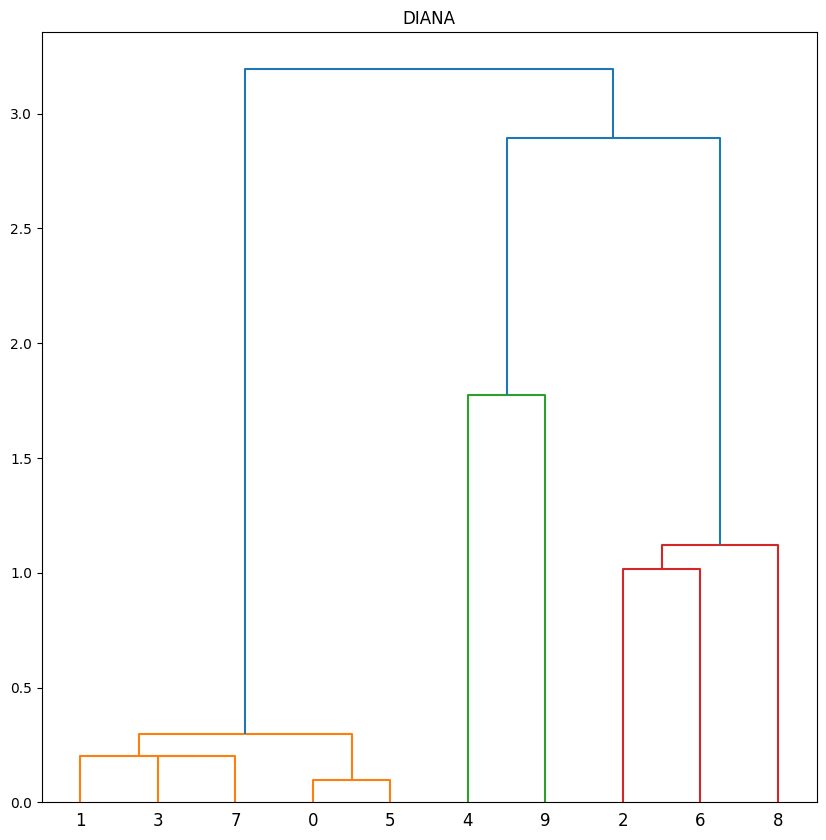

In [7]:
VQE_divisive_clustering.plot_dendrogram()

#### Viewing the split at each iteration

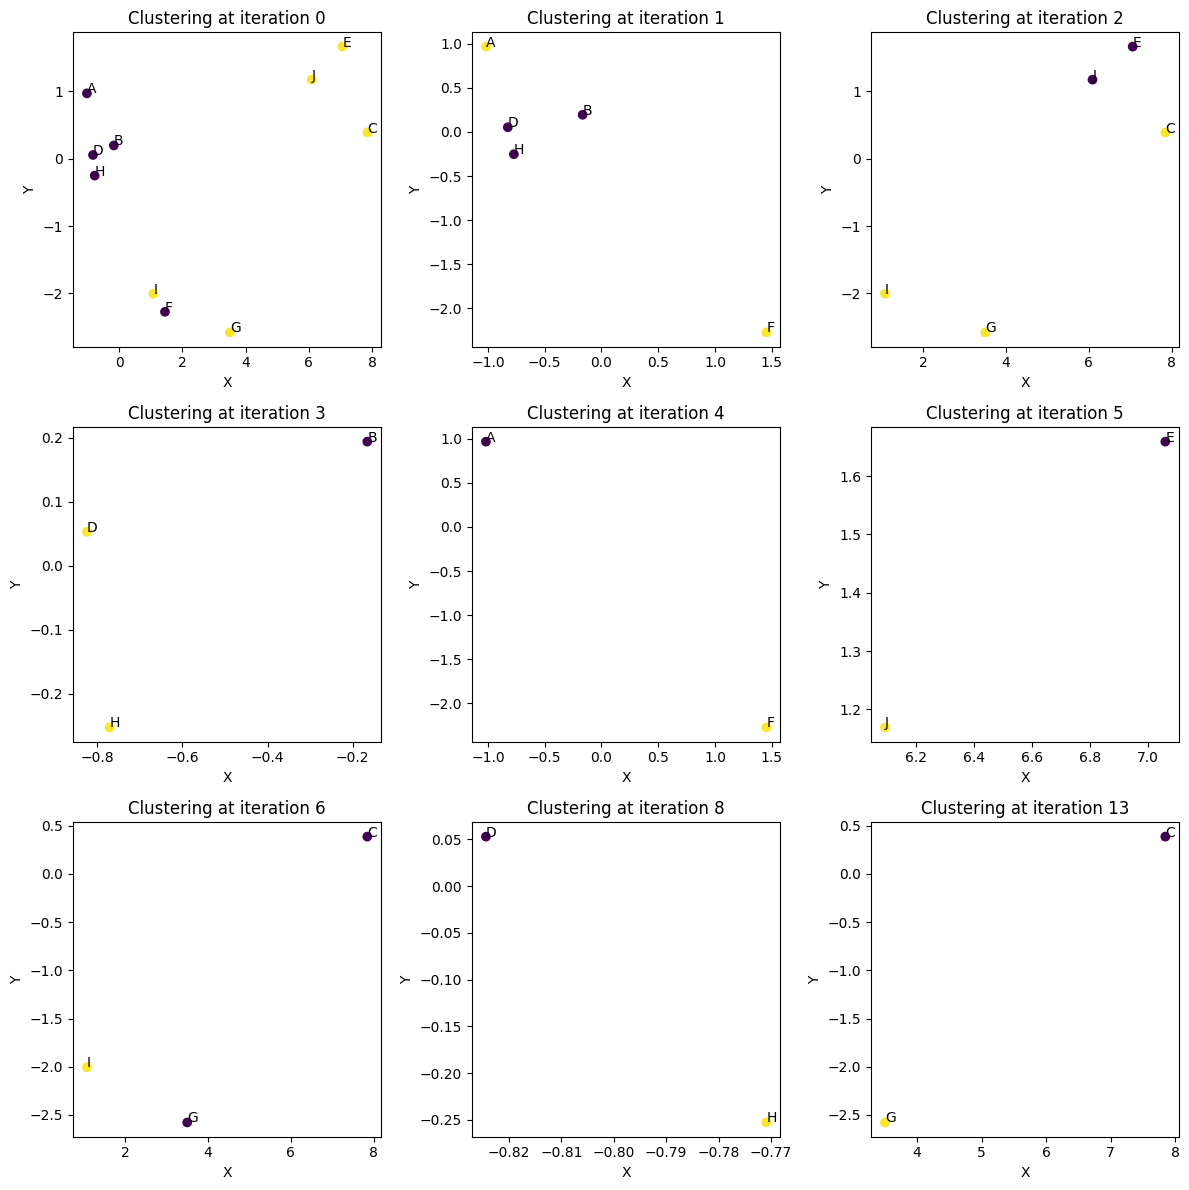

In [8]:
VQE_divisive_clustering.plot_hierarchial_split()

#### Converting Hierarchical Clustering to Flat Clustering

In [9]:
clusters = VQE_divisive_clustering.get_clusters_using_k(k=4)
print(f"Clusters from k: {clusters}")

Clusters from k: [0 0 2 0 1 0 2 0 2 1]


In [10]:
clusters = VQE_divisive_clustering.get_clusters_using_height(threshold=2)
print(f"Clusters from height: {clusters}")

Clusters from height: [0 0 2 0 1 0 2 0 2 1]


### Voronoi Tessellation

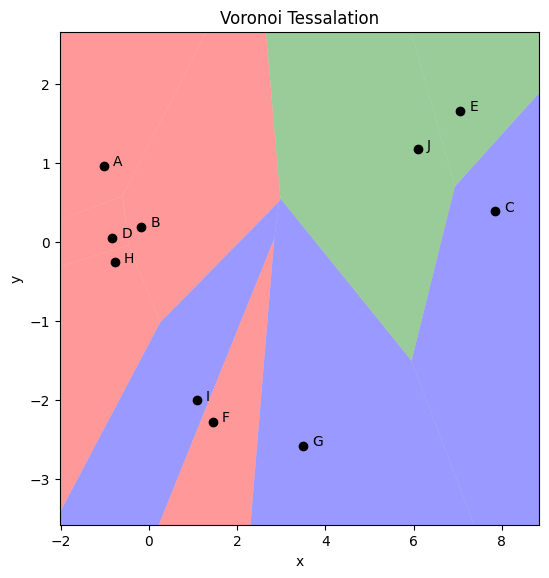

In [11]:
colors = ["red", "green", "blue", "yellow", "purple", "black"]

VQE_divisive_clustering.plot_voironi(
    clusters=clusters, colors=colors, show_annotation=True, show_scatters=True
)

## QAOA clustering

In [12]:
optimizer = cudaq.optimizers.COBYLA()

QAOA_divisive_clustering = DivisiveClusteringVQA(
    coreset_df=coreset_df,
    vector_columns=["X", "Y"],
    weights_column="weights",
    circuit_depth=circuit_depth,
    max_iterations=max_iterations,
    max_shots=max_shots,
    threshold_for_max_cut=0.75,
    create_Hamiltonian=get_K2_Hamiltonian,
    optimizer=optimizer,
    optimizer_function=get_optimizer_for_QAOA,
    create_circuit=get_QAOA_circuit,
    normalize_vectors=True,
    sort_by_descending=True,
    coreset_to_graph_metric="dist",
)

QAOA_divisive_clustering.fit()

QAOA_cost = QAOA_divisive_clustering.cost

print(f"cost: {QAOA_cost}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 50533.78it/s]

cost: 56.035521154366535


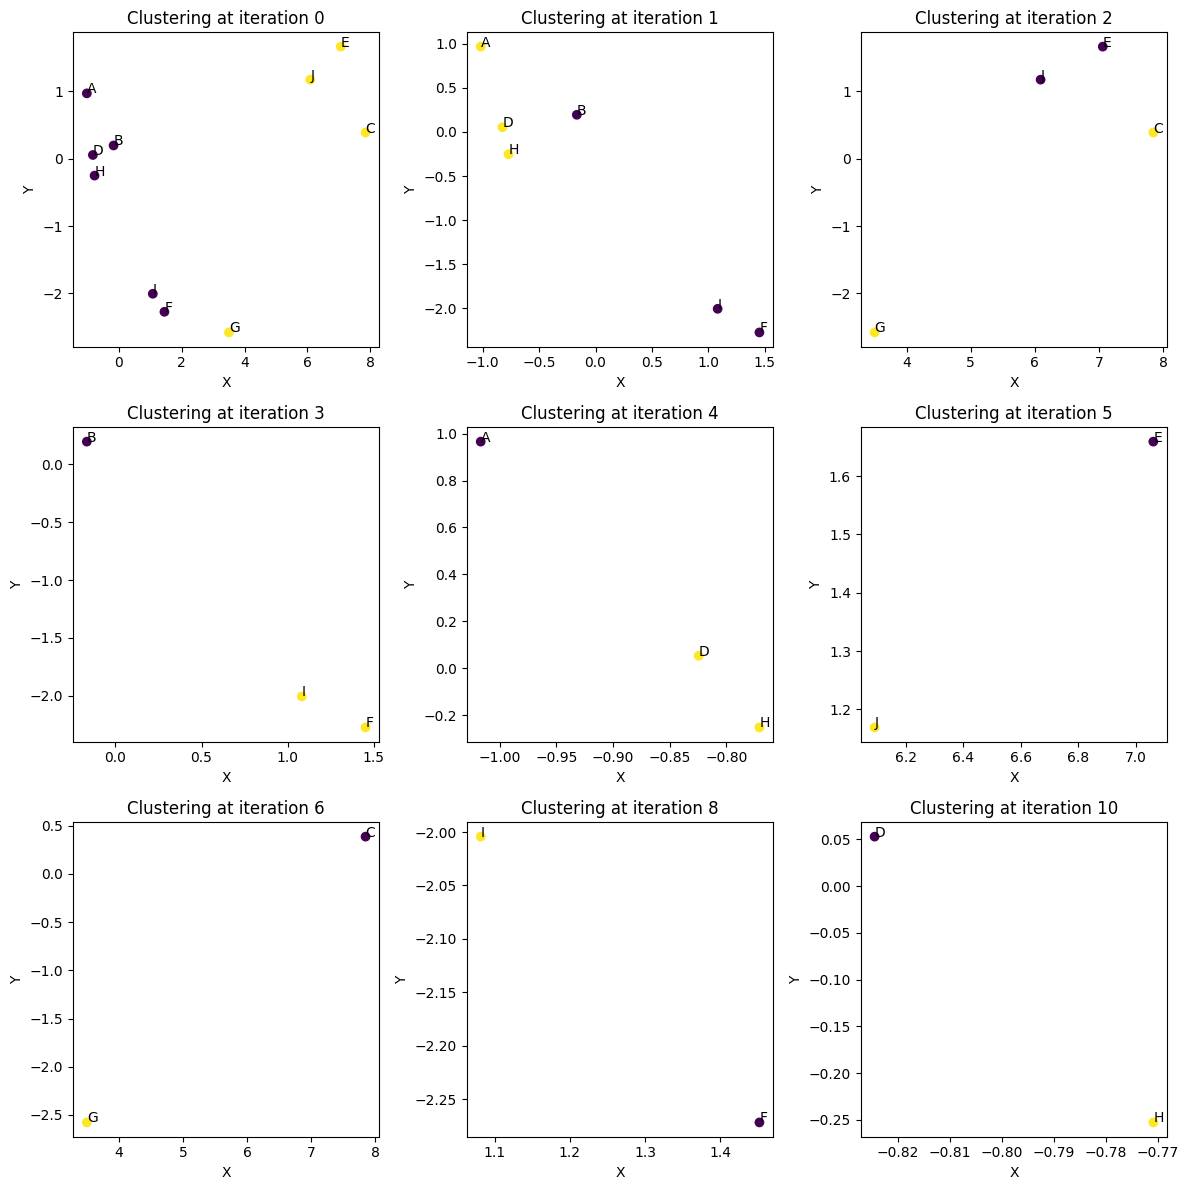

In [13]:
QAOA_divisive_clustering.plot_hierarchial_split()

## Random clustering

In [14]:
random_divisive_clustering = DivisiveClusteringRandom(
    coreset_df, vector_columns=vector_columns, weights_column=weights_column
)

random_divisive_clustering.fit()

random_cost = random_divisive_clustering.cost

print(f"Random cost: {random_cost}")

Random cost: 176.3556010605471


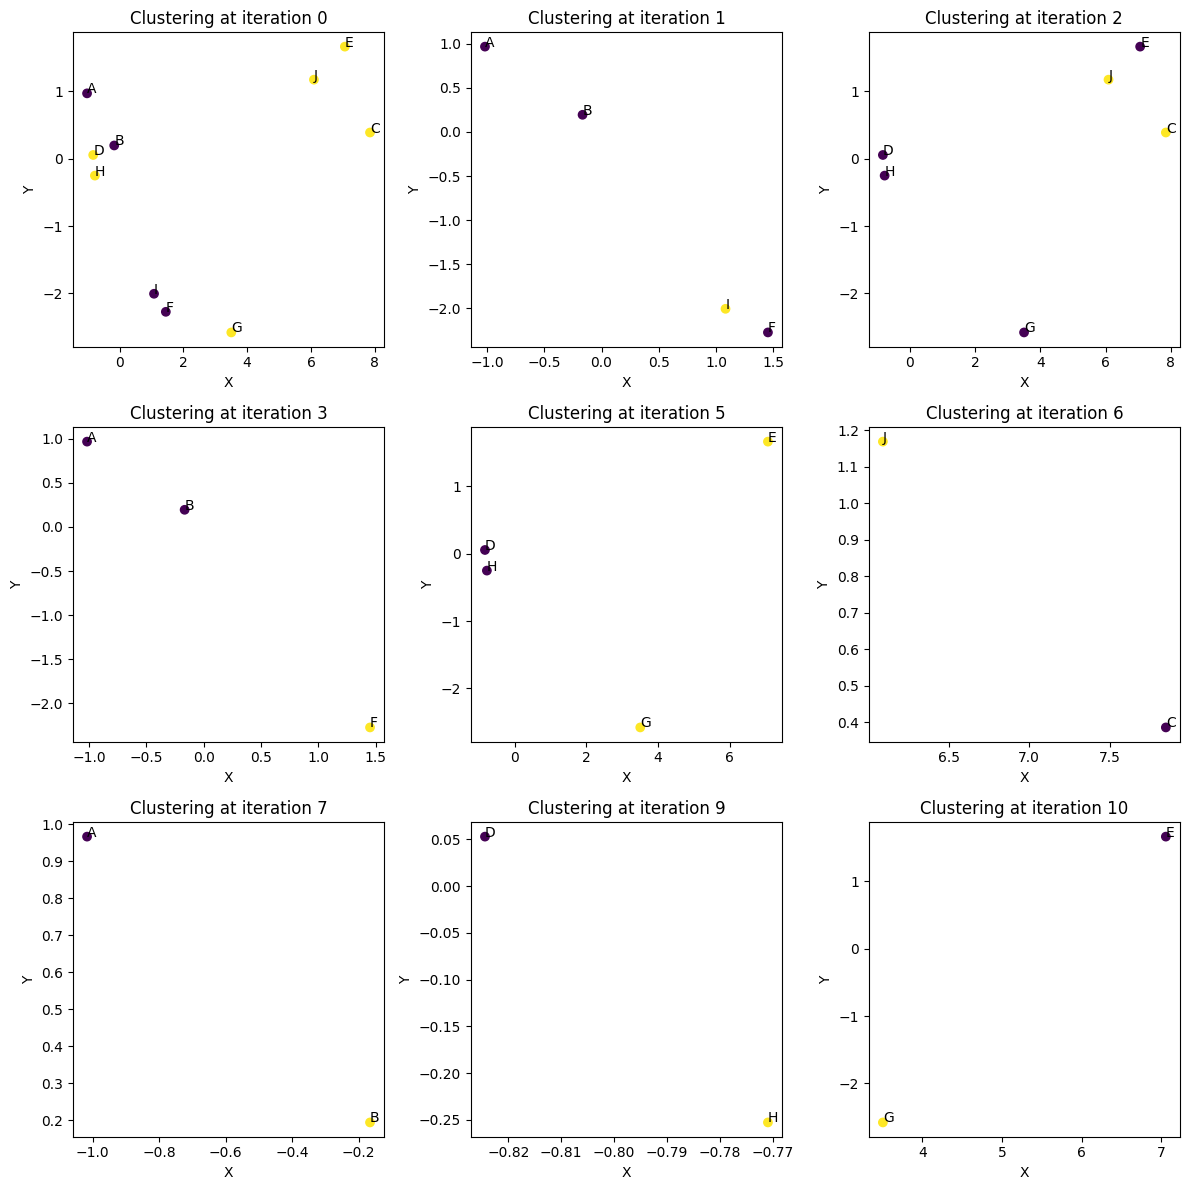

In [15]:
random_divisive_clustering.plot_hierarchial_split()

## KMeans clustering

In [16]:
KMeans_divisive_clustering = DivisiveClusteringKMeans(
    coreset_df, vector_columns=vector_columns, weights_column=weights_column
)

KMeans_divisive_clustering.fit()

KMeans_cost = KMeans_divisive_clustering.cost

print(f"Random cost: {KMeans_cost}")

Random cost: 36.52992957526641


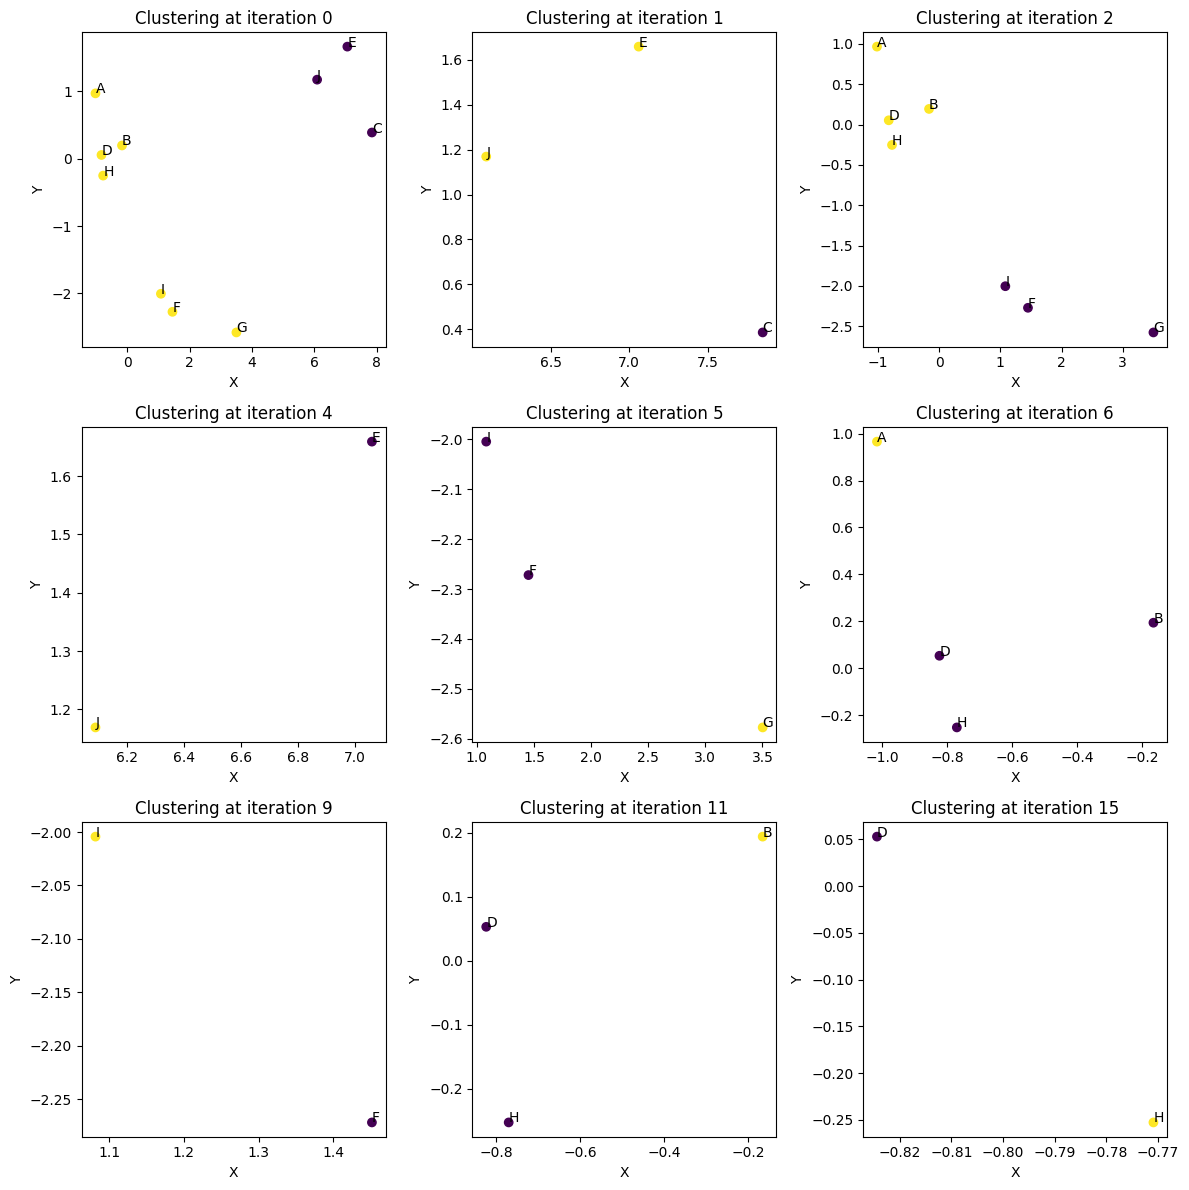

In [17]:
KMeans_divisive_clustering.plot_hierarchial_split()

## MaxCut Clustering

In [18]:
MaxCut_divisive_clustering = DivisiveClusteringMaxCut(
    coreset_df, vector_columns=vector_columns, weights_column=weights_column
)

MaxCut_divisive_clustering.fit()

MaxCut_cost = MaxCut_divisive_clustering.cost

print(f"Random cost: {KMeans_cost}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 82011.53it/s]

Random cost: 36.52992957526641


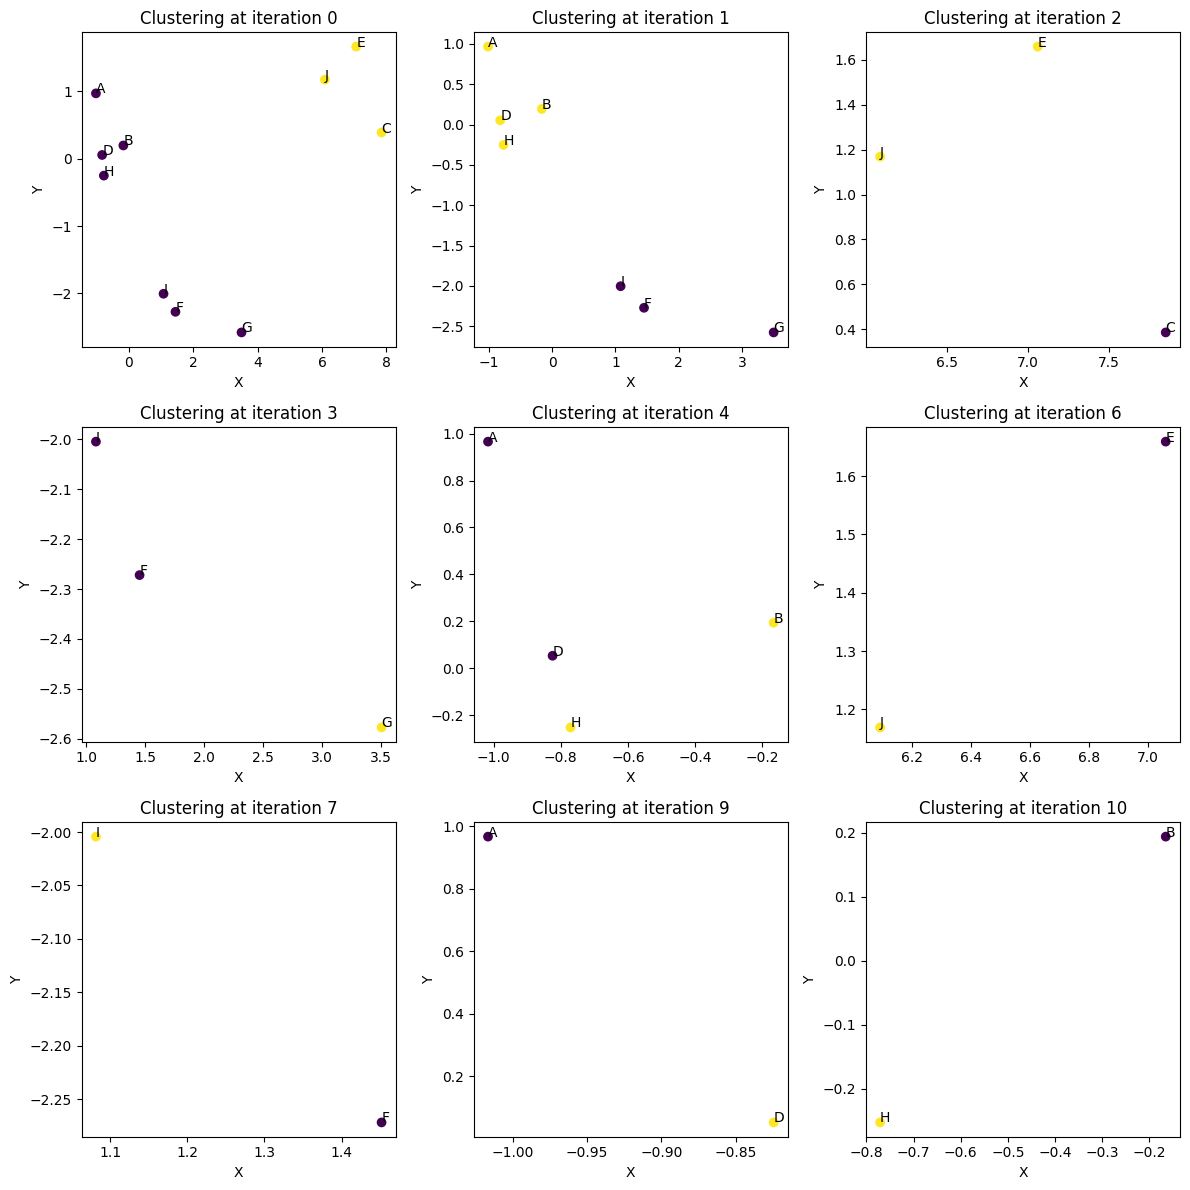

In [19]:
MaxCut_divisive_clustering.plot_hierarchial_split()

## Visualizing the cost output

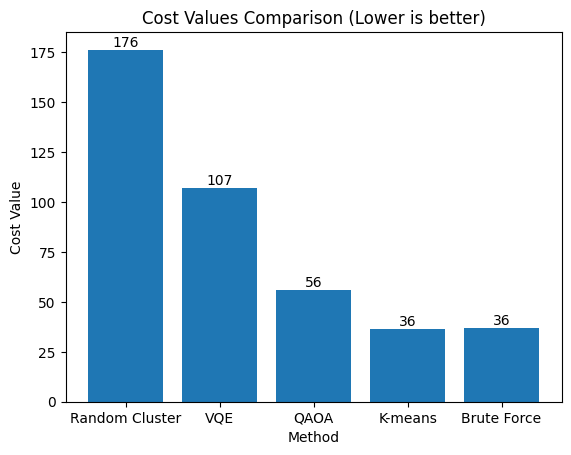

In [20]:
cost_values = [random_cost, VQE_cost, QAOA_cost,KMeans_cost, MaxCut_cost]

labels = ["Random Cluster", "VQE", "QAOA","K-means", "Brute Force"]

plt.bar(labels, cost_values)

# Display cost values on top of each bar
for i, v in enumerate(cost_values):
    plt.text(i, v, int(v), ha="center", va="bottom")

plt.xlabel("Method")
plt.ylabel("Cost Value")
plt.title("Cost Values Comparison (Lower is better)")

plt.show()